# Ildebrando Magnani

## Joint Work with Francesco Furno

## Problem Set 3 - Econ

### Exercise 2:

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import time
from ar1_approx import integrand
from ar1_approx import addacooper
import numpy as np
import scipy.stats as st
from scipy.stats import norm
import scipy.integrate as integrate
import numba

# to print plots inline
%matplotlib inline

In [2]:
# specify parameters
alpha_k = 0.29715
alpha_l = 0.65
delta = 0.154
psi = 0.03
w = 0.7
r= 0.04
sigma_z = 0.213
mu = 0.0
rho = 0.7605
sizez = 9
zz=1
betafirm = (1 / (1 + r))
dens = 5

In [3]:
# put in bounds here for the capital stock space
kstar = ((((1 / betafirm - 1 + delta) * ((w / alpha_l) **
                                         (alpha_l / (1 - alpha_l)))) /
         (alpha_k * (zz ** (1 / (1 - alpha_l))))) **
         ((1 - alpha_l) / (alpha_k + alpha_l - 1)))
kbar = 2*kstar
lb_k = 0.001
ub_k = kbar
krat = np.log(lb_k / ub_k)
numb = np.ceil(krat / np.log(1 - delta))
K = np.zeros(int(numb * dens))
# we'll create in a way where we pin down the upper bound - since
# the distance will be small near the lower bound, we'll miss that by little
for j in range(int(numb * dens)):
    K[j] = ub_k * (1 - delta) ** (j / dens)
k_grid = K[::-1]
sizek = k_grid.shape[0]

ln_z_grid, pi = addacooper(sizez, mu, rho, sigma_z)
z_grid = np.exp(ln_z_grid)
print(z_grid)

[ 0.57170087  0.72611947  0.82344962  0.91128377  1.          1.09735302
  1.21440337  1.37718384  1.74916648]


In [17]:
def o_profits(K_grid, Z_grid, sizek, sizez):
    
    op = np.zeros((sizek, sizez))
    
    for i, k in enumerate(K_grid):
        for j, z in enumerate(Z_grid):
            op[i,j] = (1-alpha_l) * ((alpha_l/w)**(alpha_l/(1-alpha_l))) * (z**(1/(1-alpha_l))) * (k**(alpha_k/(1-alpha_l)))
    return op
        

def cash_flow(K_grid, Z_grid, sizek, sizez, op):
    
    e_inv = np.zeros((sizek, sizez, sizek))
    e_noinv = np.zeros((sizek, sizez, sizek))
    
    for i, k in enumerate(K_grid):
        for j, z in enumerate(Z_grid):
            for h, k_prime in enumerate(K_grid):
                e_inv[i,j,h] = op[i,j] - (k_prime - (1-delta)*k) - psi * k
                e_noinv[i,j,h] = op[i,j]
    return e_inv, e_noinv

In [5]:
@numba.jit
def VFI_inv_step(V, K_grid, Z_grid, Pij, cash_fl_inv):
    
    V_store = np.zeros((sizek, sizez, sizek))
    
    for i, k in enumerate(K_grid):
        for j, z in enumerate(Z_grid):
            for h, k_prime in enumerate(K_grid):   
                
                P_given_z = Pij[j,:].reshape(1,9)
                V_given_k_prime = V[h,:].reshape(1,9)
                V_store[i,j,h] = cash_fl_inv[i,j,h] + betafirm * np.sum(P_given_z * V_given_k_prime)
    
    return V_store

@numba.jit
def VFI_noinv_step(V, K_grid, Z_grid, Pij, cash_fl_noinv):
    
    V_store = np.zeros((sizek, sizez, sizek))
    
    for i, k in enumerate(K_grid):
        for j, z in enumerate(Z_grid):
            for h, k_prime in enumerate(K_grid):   
                
                if i > dens:
                    P_given_z = Pij[j,:].reshape(1,9)
                    V_given_k_prime = V[i-dens,:].reshape(1,9)
                    V_store[i,j,h] = cash_fl_noinv[i,j,h] + betafirm * np.sum(P_given_z * V_given_k_prime)
                else:
                    P_given_z = Pij[j,:].reshape(1,9)
                    V_given_k_prime = V[0,:].reshape(1,9)
                    V_store[i,j,h] = cash_fl_noinv[i,j,h] + betafirm * np.sum(P_given_z * V_given_k_prime) 
    
    return V_store

In [27]:
@numba.jit
def V_max(V_inv, V_noinv, PF_inv, K_grid, Z_grid):
    
    V_next = np.zeros((sizek, sizez))
    PF = np.zeros_like(PF_inv)
    
    for i, k in enumerate(K_grid):
        for j, z in enumerate(Z_grid):
            
            if V_inv[i,j] > V_noinv[i,j]:
                V_next[i,j] = V_inv[i,j]
                PF[i,j] = K_grid[PF_inv[i,j]]
            else:
                V_next[i,j] = V_noinv[i,j]
                if i > dens:
                    PF[i,j] = K_grid[i-dens]
                else:
                    PF[i,j] = K_grid[0]
    return V_next, PF

In [42]:
@numba.jit
def bellman_operator(V, K_grid, Z_grid, Pij, cash_fl_inv, cash_fl_noinv):
        
    V_inv = VFI_inv_step(V, K_grid, Z_grid, Pij, cash_fl_inv)
    V_noinv = VFI_noinv_step(V, K_grid, Z_grid, Pij, cash_fl_noinv)
    
    V_inv_max = V_inv.max(axis=2)
    PF_inv = np.argmax(V_inv, axis=2)
    V_noinv_max = V_noinv.max(axis=2)
    
    V_next, PF = V_max(V_inv_max, V_noinv_max, PF_inv, K_grid, Z_grid)
    
    return V_next, PF

In [52]:
def VFI(V, K_grid, Z_grid, Pij):
    
    VFtol = 1e-6
    VFdist = 7.0
    VFmaxiter = 3000
    VFiter = 1
    
    op = o_profits(K_grid, Z_grid, sizek, sizez)
    e_inv, e_noinv = cash_flow(K_grid, Z_grid, sizek, sizez, op)
    
    while VFdist > VFtol and VFiter < VFmaxiter:
        TV = V
        V, PF = bellman_operator(V, K_grid, Z_grid, Pij, e_inv, e_noinv)
        VFdist = (np.absolute(V - TV)).max()
        VFiter += 1
        
        if VFdist < VFtol:
                print("VFI converged after", VFiter, "iterations")
    
    VF_star = V
    PF_index = PF
    
    return VF_star, PF

In [53]:
V = np.zeros((sizek, sizez))

In [54]:
vn, pf = VFI(V, k_grid, z_grid, pi)

VFI converged after 368 iterations


In [64]:
k_grid1 = k_grid.reshape((285,1))

PF = k_grid[pf]
I = PF - ((1 - delta) * k_grid1)

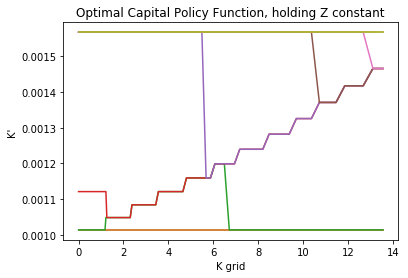

In [65]:
for i in range(sizez):
    plt.plot(k_grid, PF[:,i])
    plt.title("Optimal Capital Policy Function, holding Z constant")
plt.xlabel("K grid")
plt.ylabel("K'")
    

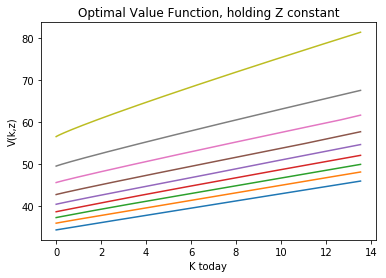

In [68]:
for i in range(sizez):
    plt.plot(k_grid, vn[:,i])
    plt.title("Optimal Value Function, holding Z constant")
plt.xlabel("K today")
plt.ylabel("V(k,z)")

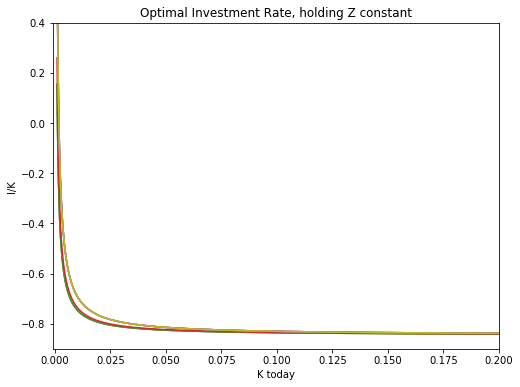

In [85]:
fig, ax = plt.subplots(figsize=(8,6))
for i in range(sizez):
    ax.plot(k_grid, I[:,i] / k_grid)
    plt.title("Optimal Investment Rate, holding Z constant")
    plt.xlabel("K today")
    plt.ylabel("I/K")
    plt.xlim(-0.001, 0.2)
    plt.ylim(-0.9, 0.4)